In [1]:
from langchain_groq import ChatGroq

from langgraph.graph import StateGraph,START,END

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser,StrOutputParser
from pydantic import BaseModel,Field
from typing import Annotated,List
import operator

from dotenv import load_dotenv
load_dotenv()


True

In [2]:
class JobData(BaseModel):
    user_info : str = Field(default= "I am Aman Prajapat interested in AI field and have good skill set in the respective field",        
                                     description="Instruction for creating a proper message")
    subject : str = Field(default="")
    body : str  = Field(default="")
    email :str = Field(default="")
    post_data :str = Field(default="")
    feedback :Annotated[List[str],operator.add] = Field(default=[])



In [25]:

post_text = """🚀 We’re Hiring! Freshers Welcome! 🚀

Are you a recent graduate ready to kick-start your career?
We’re looking for enthusiastic and passionate freshers to join our growing team at QSS Technosoft!

🔹 Position: Software Engineer
🔹 Location: Noida
🔹 Experience: 0–1 year (Freshers encouraged to apply)

What we’re looking for:
✅ A strong willingness to learn and grow
✅ Good communication and problem-solving skills
✅ A positive attitude and team spirit
✅ Basic knowledge of relevant tools/skills

What we offer:
🌱 Mentorship and hands-on training
🚀 Growth opportunities in a dynamic work environment
🤝 A collaborative, inclusive company culture
💼 Competitive salary and benefits

If you’re eager to begin your professional journey with a company that values learning and innovation — we’d love to hear from you!
📩 Apply now by sending your resume to prajapataman007@gmail.com
"""

# create the JobData object with only instruction and post_data
job = JobData(
    instrctions="You are an expert in writing short and concise emails. Keep subject punchy and body ~3-5 short sentences.",
    post_data=post_text
)


In [26]:
model = ChatGroq(model= "openai/gpt-oss-120b",temperature=0.3)

In [27]:
# email extractor
def extract_mail_id(state:JobData):
    prompt = PromptTemplate(
        template= "From the text below, extract ONLY the email address  where the candidate has to apply.  Return ONLY the email (no other text).\n\n Post content:\n{post_data}"
    )
    mail_chain = prompt | model | StrOutputParser()

    email = mail_chain.invoke({'post_data':state.post_data})

    return {'email':email}

In [28]:
extract_mail_id(job)

{'email': 'prajapataman007@gmail.com'}

In [ ]:

def create_mail(state: JobData):
    prompt = PromptTemplate(
        template=(
            "You are an expert email writer.\n"
            "Use the following details to create a professional job application email.\n\n"
            "The email should be short and sweet with no place holders because its a automation system for send mail.\n"
            "User information:\n{user_information}\n\n"
            "Job Post Content:\n{post_data}\n\n"
            "Now generate the email in JSON format as shown:\n"
            "{{\n"
            '  "subject": "Your email subject",\n'
            '  "body": "Your email body with proper formating"\n'
            "}}"
        ),
        input_variables=["user_information", "feedback", "post_data"]
    )

    mail_chain = prompt | model | JsonOutputParser()

    # Step 3: Invoke model
    response = mail_chain.invoke({
        "user_information": state.user_info,
        "post_data": state.post_data
    })


    return {'body':response["body"],'subject':response['subject']}


In [30]:
res = create_mail(job)
print(res['subject'])
print(res['body'])

Application for Software Engineer Position – Aman Prajapat
Dear Hiring Team,

I am writing to express my interest in the Software Engineer role at QSS Technosoft (Noida) as advertised. I am a recent graduate with a strong passion for AI and a solid skill set in relevant tools, problem‑solving, and communication.

I am eager to learn, contribute, and grow within your dynamic team. Please find my resume attached for your review.

Thank you for considering my application.

Best regards,
Aman Prajapat
Email: prajapataman007@gmail.com


In [31]:
def update_mail(state: JobData):
    feedback = input("write your feedback")
    prompt = PromptTemplate(
        template=(
            "You are an expert email rewriter.\n"
            "Your task is to update the existing email according to the user's feedback. "
            "The email should be short and sweet with no place holders because its a automation system for send mail.\n"
            "### Feedback :\n{feedback}\n\n"
            "### Previous Email:\n"
            "Subject: {subject}\n"
            "Body: {body}\n\n"
            "Now rewrite the email according to the feedback. "
            "Return the response in JSON format as follows:\n"
            "{{\n"
            '  "subject": "Updated subject",\n'
            '  "body": "Updated body"\n'
            "}}"
        ),
        input_variables=["feedback", "subject", "body"]
    )

    # Step 2: Build LLM chain
    update_chain = prompt | model | JsonOutputParser()

    # Step 3: Generate updated mail
    response = update_chain.invoke({
        "feedback": feedback,
        "subject": state.subject,
        "body": state.body
    })


    return {
        "subject": response['subject'],
        "body": response['body'],
        "feedback": [feedback],
    }


In [32]:
job.feedback = "just add one line in which i showed that i have done two internship in the ai field in which craeted chatbot and also fine tuned a llm and deployed the company projects"

In [33]:
job.feedback

'just add one line in which i showed that i have done two internship in the ai field in which craeted chatbot and also fine tuned a llm and deployed the company projects'

In [34]:
data = update_mail(job)
print(res['subject'])
print(res['body'])

Application for Software Engineer Position – Aman Prajapat
Dear Hiring Team,

I am writing to express my interest in the Software Engineer role at QSS Technosoft (Noida) as advertised. I am a recent graduate with a strong passion for AI and a solid skill set in relevant tools, problem‑solving, and communication.

I am eager to learn, contribute, and grow within your dynamic team. Please find my resume attached for your review.

Thank you for considering my application.

Best regards,
Aman Prajapat
Email: prajapataman007@gmail.com


## LangGraph Part

In [35]:

import smtplib
from email.message import EmailMessage
import os

GMAIL = os.getenv("MAIL")
APP_PASSWORD = os.getenv("PASSWORD")  

def send_mail(state:JobData):
    msg = EmailMessage()
    msg["From"] = GMAIL
    msg["To"] = state.email
    msg["Subject"] = state.subject
    msg.set_content(state.body)

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
        smtp.login(GMAIL, APP_PASSWORD)
        smtp.send_message(msg)

    print("email delivered")
    return state


In [36]:
print(os.getenv("MAIL"))

prajapataman0072@gmail.com


In [37]:
def wantToupdateMail(state:JobData):
    condition = input("want to update the mail")

    if condition== "yes":
        
        return "update_mail"
    else:
        return "send_email"

In [38]:



def get_data(state:JobData):
    state.post_data = post_text
    state.user_info = "You are an expert in writing short and concise emails. Keep subject punchy and body ~3-5 short sentences."
    return state


In [39]:
from langgraph.types import interrupt, Command

def human_approval(state:JobData):
    response = interrupt({
        "question": "Do you want to send this email?",
    })

    if response:
        return Command(goto="send_mail")
    else:
        return Command(goto="update_mail")



In [40]:
applyGraph = StateGraph(JobData)

applyGraph.add_node("input", get_data)
applyGraph.add_node("find_email", extract_mail_id)
applyGraph.add_node("gen_body_sub", create_mail)
applyGraph.add_node("update_mail", update_mail)
applyGraph.add_node("human_approval", human_approval)
applyGraph.add_node("send_mail", send_mail)

applyGraph.add_edge(START, "input")
applyGraph.add_edge("input", "find_email")
applyGraph.add_edge("find_email", "gen_body_sub")

applyGraph.add_conditional_edges(
    "gen_body_sub",
    wantToupdateMail,
    {
        "update_mail": "update_mail",
        "send_email": "human_approval",
    }
)

applyGraph.add_conditional_edges(
    "update_mail",
    wantToupdateMail,
    {
        "update_mail": "update_mail",
        "send_email": "human_approval",
    }
)

applyGraph.add_edge("human_approval", "send_mail")
applyGraph.add_edge("send_mail", END)


In [41]:
# workflow.invoke(
#     input=previous_state,
#     config={"resume": "human_approval"}
# )


In [42]:
from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()
workflow = applyGraph.compile(checkpointer=checkpointer)



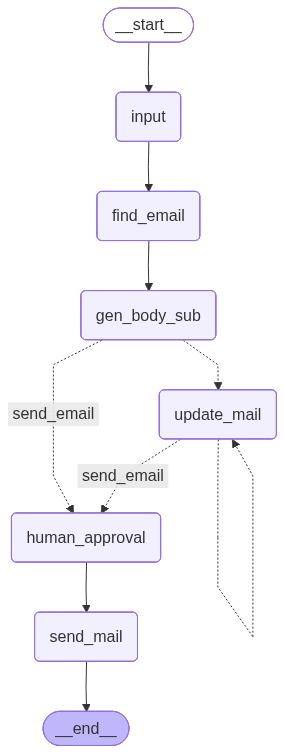

In [43]:
workflow

In [44]:
config = {'configurable':{'thread_id':1}}

state1 = workflow.invoke({},config=config)

In [45]:
state1

{'user_info': 'You are an expert in writing short and concise emails. Keep subject punchy and body ~3-5 short sentences.',
 'subject': 'Application for Software Engineer – Fresh Graduate',
 'body': 'Dear Hiring Team,\n\nI am writing to apply for the Software Engineer position at QSS Technosoft in Noida. As a recent graduate with a solid foundation in programming and a strong eagerness to learn, I am excited about the mentorship and growth opportunities you offer. My communication skills, problem‑solving mindset, and positive attitude make me a good fit for your collaborative team.\n\nPlease find my resume attached for your review. Thank you for considering my application.\n\nBest regards,\n[Your Name]\n[Phone Number]\n[LinkedIn Profile]',
 'email': 'prajapataman007@gmail.com',
 'post_data': '🚀 We’re Hiring! Freshers Welcome! 🚀\n\nAre you a recent graduate ready to kick-start your career?\nWe’re looking for enthusiastic and passionate freshers to join our growing team at QSS Technosoft!

In [46]:
from langgraph.types import Command
workflow.invoke(
    Command(resume=True), 
    config=config

)

email delivered


{'user_info': 'You are an expert in writing short and concise emails. Keep subject punchy and body ~3-5 short sentences.',
 'subject': 'Application for Software Engineer – Fresh Graduate',
 'body': 'Dear Hiring Team,\n\nI am writing to apply for the Software Engineer position at QSS Technosoft in Noida. As a recent graduate with a solid foundation in programming and a strong eagerness to learn, I am excited about the mentorship and growth opportunities you offer. My communication skills, problem‑solving mindset, and positive attitude make me a good fit for your collaborative team.\n\nPlease find my resume attached for your review. Thank you for considering my application.\n\nBest regards,\n[Your Name]\n[Phone Number]\n[LinkedIn Profile]',
 'email': 'prajapataman007@gmail.com',
 'post_data': '🚀 We’re Hiring! Freshers Welcome! 🚀\n\nAre you a recent graduate ready to kick-start your career?\nWe’re looking for enthusiastic and passionate freshers to join our growing team at QSS Technosoft!

In [23]:
from dotenv import load_dotenv
import os

load_dotenv()

GMAIL = os.getenv("MAIL")
APP_PASSWORD = os.getenv("PASSWORD")

print(GMAIL, APP_PASSWORD)


prajapataman0072@gmail.com kpzea iosl dbtc zxil
